In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import glob
import tqdm
import pickle
import numpy as np
import seaborn as sns
from toolz.curried import pipe, curry, compose

In [4]:
import scipy
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
from skimage import data, img_as_float

from scipy.spatial.distance import cdist
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

In [5]:
import skimage
import skimage.feature as features
import skimage.morphology as morph
import skimage.segmentation as seg
import scipy.ndimage.filters as spy_filters
import skimage.filters as skm_filters

In [6]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 24
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [7]:
import plot
import atommks.helpers as utils

In [8]:
@curry
def thresh(im, h):
    return im > h

@curry
def get_peak_coords(data, size=5, threshold=0.8):

    data_max = max_filter(size=size)(data)
    maxima = (data == data_max)
    data_min = min_filter(size=size)(data)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = int(np.round((dx.start + dx.stop - 1)/2))
        x.append(x_center)
        y_center = int(np.round((dy.start + dy.stop - 1)/2))    
        y.append(y_center)
        
    return x, y

@curry
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w//2), int(h//2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

bool_to_int = lambda x: x*1

to_log = lambda x: np.log10(x)

## Filters
sobel = curry(skm_filters.sobel)
blur = curry(skm_filters.gaussian)
erode = curry(morph.binary_erosion)
opening = curry(morph.binary_opening)
max_filter = curry(ndimage.maximum_filter)
min_filter = curry(ndimage.minimum_filter)

In [9]:
runs = np.loadtxt("runs.txt").astype(int)

image shape: (2049, 2049)


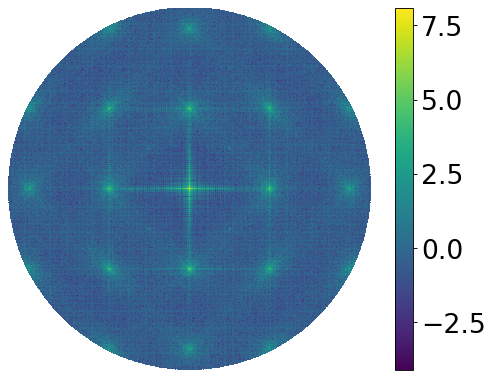

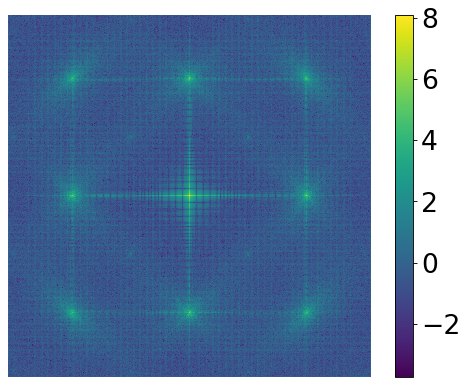

In [83]:
dx = 2048
ix = 1
f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, runs[ix], dx)
img = utils.load_file(f_saed)
img_log = np.log10(img)

print("image shape: {}".format(img.shape))

plot.draw_2d(img_log)
plot.draw_2d(utils.return_slice(cutoff=700, s=None)(img_log))

## Identify peak coordinates in undisturbed structure

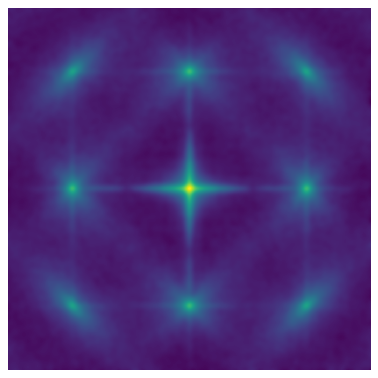

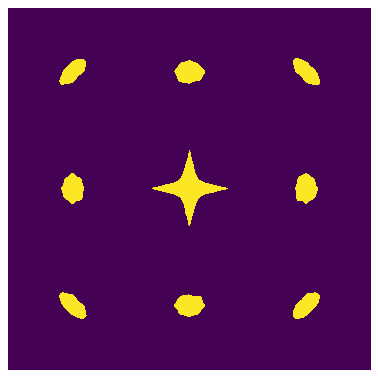

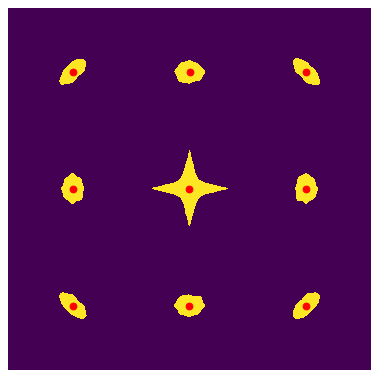

x coordinates: [1152, 249, 702, 701, 250, 1151, 250, 1150, 700]
y coordinates: [248, 249, 250, 700, 700, 700, 1152, 1152, 1152]
x coordinates: [1152, 249, 702, 250, 1151, 250, 1150, 700]
y coordinates: [248, 249, 250, 700, 700, 1152, 1152, 1152]


In [22]:
dx = 1024 * 2
ix = 0
threshold=0.5
sigma=10
selem=np.ones((3,3))

slicer = utils.return_slice(cutoff=175 * dx // 512, s=None)

f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, runs[ix], dx)
img = utils.load_file(f_saed)
img_log = np.log10(img)


transformer = compose(bool_to_int, opening, erode(selem=selem), thresh(h=threshold), blur(sigma=sigma), slicer)

img_t = transformer(img_log)
x_coord_ud, y_coord_ud = get_peak_coords(img_t, size=5)

plt.imshow(compose(blur(sigma=sigma), slicer)(img_log))
plt.autoscale(False)
plt.axis('off')
plt.show()

plt.imshow(img_t)
plt.autoscale(False)
# plt.plot(x_coord_ud, y_coord_ud, 'ro')
plt.axis('off')
plt.show()

plt.imshow(img_t)
plt.autoscale(False)
plt.plot(x_coord_ud, y_coord_ud, 'ro')
plt.axis('off')
plt.show()

print("x coordinates: {}".format(x_coord_ud))
print("y coordinates: {}".format(y_coord_ud))
del x_coord_ud[3]
del y_coord_ud[3]
print("x coordinates: {}".format(x_coord_ud))
print("y coordinates: {}".format(y_coord_ud))

## Generate Mask

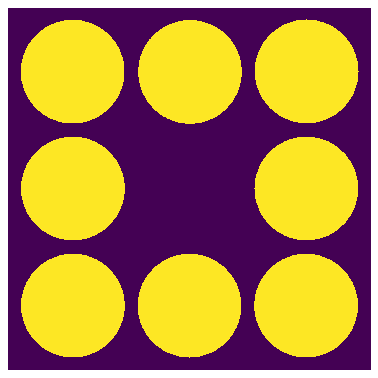

In [28]:
h = 175 * dx // 512 * 2 + 1
w = h
r_mask = 100 * 2
mask = np.zeros((h, w))

mask_list = []
for ix, _ in enumerate(x_coord_ud):
    mask_list.append(create_circular_mask(h, w, radius=r_mask, center=(x_coord_ud[ix], y_coord_ud[ix])))
    mask += mask_list[-1]
    
mask_list_1 = []
for ix in [0, 1, 5, 6]:
    mask_list_1.append(create_circular_mask(h, w, radius=r_mask, center=(x_coord_ud[ix], y_coord_ud[ix])))

    
mask_list_2 = []
for ix in [2, 3, 4, 7]:
    mask_list_2.append(create_circular_mask(h, w, radius=r_mask, center=(x_coord_ud[ix], y_coord_ud[ix])))

# plot.draw_2d(mask)

plt.imshow(mask)
plt.autoscale(False)
plt.axis('off')
plt.show()

## Apply mask

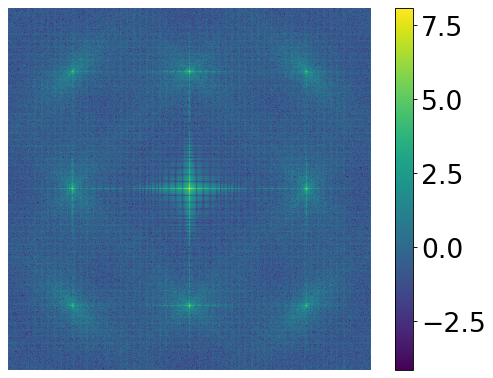

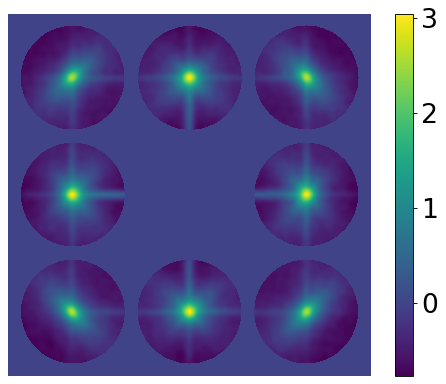

In [26]:
ix = 1
f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, runs[ix], dx)

apply_mask = lambda x: x * mask

img_new = compose(apply_mask, blur(sigma=10), slicer, to_log, utils.load_file)(f_saed)

plot.draw_2d(slicer(img_log))
plot.draw_2d(img_new)

## Identify peak coordinates in disturbed structures

x coordinates: [693, 1142, 254, 1130, 280, 708, 259, 1152]
y coordinates: [310, 250, 256, 701, 704, 1102, 1144, 1141]


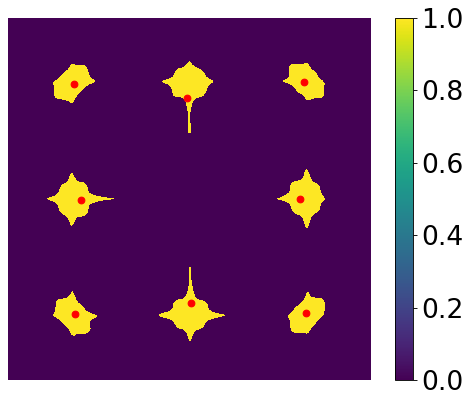

In [36]:
ix = -1

slicer = utils.return_slice(cutoff=175 * dx // 512, s=None)

f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, runs[ix], dx)
img = utils.load_file(f_saed)
img_log = np.log10(img)

transformer = compose(bool_to_int, 
                      opening, 
                      erode(selem=selem), 
                      thresh(h=threshold), 
                      apply_mask, 
                      blur(sigma=sigma), 
                      slicer)

img_t = transformer(img_log)
x_coord, y_coord = get_peak_coords(img_t, size=5)

print("x coordinates: {}".format(x_coord))
print("y coordinates: {}".format(y_coord))

plt.imshow(img_t)
plt.autoscale(False)
plt.plot(x_coord,y_coord, 'ro')
plt.axis('off')
plt.colorbar()
plt.show()

In [38]:
dist = lambda x: np.sqrt(np.sum((np.array(x)-np.array([700, 700]))**2))
for m0 in mask_list_1:
    img_m = img_t * m0
    props = skimage.measure.regionprops(img_t * m0)[0]
    print(props.area, props.perimeter, dist(props.centroid), props.eccentricity, props.equivalent_diameter)
    
for m0 in mask_list_2:
    img_m = img_t * m0
    props = skimage.measure.regionprops(img_t * m0)[0]
    print(props.area, props.perimeter, dist(props.centroid), props.eccentricity, props.equivalent_diameter)

14287 501.04372260139576 636.9079714805936 0.7724269854717813 134.8731751521824
14451 502.8843430349616 635.3643772071734 0.7502657491893611 135.6450686938815
15347 548.0975464705581 635.2612557899973 0.7327232364915588 139.7870068820795
14167 489.5290039756343 636.2982612728076 0.7780541343939211 134.30556440543725
18514 798.5239533417508 434.8799872845648 0.6364933745049401 153.53422071716392
18888 759.494516090228 441.9522482049003 0.4356944843522756 155.07723405115837
18273 665.5950211536164 444.0747284947461 0.5836453984381313 152.53165638956926
20551 933.7787873376899 440.1594111193529 0.21034047501151298 161.76014924527095


In [30]:
peaks_1 = []
peaks_2 = []
for run in tqdm.tqdm_notebook(runs):

    slicer = utils.return_slice(cutoff=175 * dx // 512, s=None)

    f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, run, dx)
    img = utils.load_file(f_saed)
    img_log = np.log10(img)

    transformer = compose(bool_to_int, 
                          opening, 
                          erode(selem=selem), 
                          thresh(h=threshold), 
                          apply_mask, 
                          blur(sigma=sigma), 
                          slicer)

    img_t = transformer(img_log)

    arrs = []
    for m0 in mask_list_1:
        img_m = img_t * m0
        props = skimage.measure.regionprops(img_t * m0)[0]
        arrs.append(np.array([props.area, 
                              props.perimeter, 
                              dist(props.centroid), 
                              props.eccentricity, 
                              props.equivalent_diameter])[None])

    peaks_1.append(np.concatenate(arrs, axis=0).mean(axis=0)[None])
    
    arrs = []
    for m0 in mask_list_2:
        img_m = img_t * m0
        props = skimage.measure.regionprops(img_t * m0)[0]
        arrs.append(np.array([props.area, 
                              props.perimeter, 
                              dist(props.centroid), 
                              props.eccentricity, 
                              props.equivalent_diameter])[None])
    peaks_2.append(np.concatenate(arrs, axis=0).mean(axis=0)[None])

In [41]:
peaks_1_arr = np.concatenate(peaks_1, axis=0)
peaks_2_arr = np.concatenate(peaks_2, axis=0)

utils.save_file(fname = "peaks_1_arr.pkl", obj=peaks_1_arr)
utils.save_file(fname = "peaks_2_arr.pkl", obj=peaks_2_arr)

In [71]:
peaks_1_max = np.zeros((len(runs), 
                        len(mask_list_1)))

for ix, run in tqdm.tqdm_notebook(enumerate(runs)):

    slicer = utils.return_slice(cutoff=175 * dx // 512, s=None)

    f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, run, dx)

    img = utils.load_file(f_saed)

    for iy, m0 in enumerate(mask_list_1):
        img_m = slicer(img) * m0
        peaks_1_max[ix, iy] = img_m.sum()
        
utils.save_file(fname = "peaks_1_max.pkl", obj=peaks_1_max)

peaks_2_max = np.zeros((len(runs), 
                        len(mask_list_1)))

for ix, run in tqdm.tqdm_notebook(enumerate(runs)):

    slicer = utils.return_slice(cutoff=175 * dx // 512, s=None)

    f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, run, dx)

    img = utils.load_file(f_saed)

    for iy, m0 in enumerate(mask_list_2):
        img_m = slicer(img) * m0
        peaks_2_max[ix, iy] = img_m.sum()
        
utils.save_file(fname = "peaks_2_max.pkl", obj=peaks_2_max)

In [68]:
peaks_sum = []
dx = 2048
slicer = utils.return_slice(cutoff=175 * dx // 512, s=None)
for ix, run in tqdm.tqdm_notebook(enumerate(runs)):
    

    f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, run, dx)

    img = utils.load_file(f_saed)
    img_m = compose(apply_mask, slicer)(img)
    peaks_sum.append(img_m.sum())
    
utils.save_file(fname = "peaks_sum.pkl", obj=peaks_sum)

In [84]:
slicer = utils.return_slice(cutoff=175 * dx // 512, s=None)

img_new_list = []
for run in tqdm.tqdm_notebook(runs):
    f_saed = "data/saeds_{}/Cu_ACC_{}_{}_saed.pkl".format(dx, run, dx)
    img_t = compose(apply_mask, blur(sigma=sigma), slicer, to_log, utils.load_file)(f_saed)
    img_new_list.append(img_t)
    
print(f_saed)

fout = "data/saed_{}_masked_imgs_hid_blur_{}.pkl".format(dx, sigma)
print(fout)
utils.save_file(fout, img_new_list)


data/saeds_2048/Cu_ACC_38000_2048_saed.pkl
data/saed_2048_masked_imgs_hid_blur_10.pkl


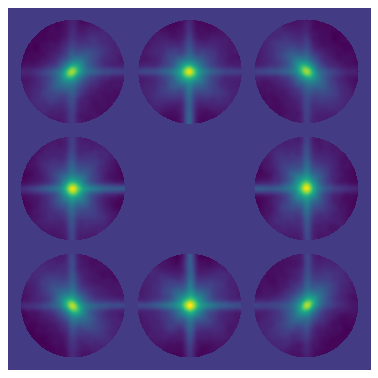

In [81]:
ix = 1
plt.imshow(img_new_list[ix])
plt.autoscale(False)
plt.axis('off')
plt.show()